# Heart Failure Prediction



We will use this data set:
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## AdaBoost

Adaptive Boosting, is an ensemble learning algorithm that is used to improve the performance of machine learning models, particularly binary classifiers. The key idea behind AdaBoost is to combine the predictions of multiple weak learners (typically decision trees with limited depth or simple rules), to create a strong classifier.

The algorithm works iteratively, assigning weights to training instances based on their classification accuracy in each iteration. Instances that are misclassified receive higher weights, making them more influential in the subsequent iteration. This adaptiveness allows AdaBoost to focus on the challenging examples, improving overall model accuracy.

In the final model, weak learners are combined using a weighted sum, with higher weights assigned to more accurate classifiers.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load data

In [2]:
relative_path = 'heart.csv'
path = os.path.join(os.getcwd(), relative_path)

df = pd.read_csv(path)

## Inspect Data

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
def inspect_data(df):
    print(f'DF has {df.shape[0]} rows and {df.shape[1]} columns')
    print(f'DF contains {df.isnull().sum().sum()} missing values')
    
    col_name = df.columns
    dtyp =  df.dtypes
    unique = df.nunique()
    missing = df.isna().sum()

    print('%38s %10s     %10s %10s' % ('Column Name', 'Data Type', 'Distinct', 'Missing Val.'))
    
    for i in range(len(df.columns)):
            print('%38s %10s   %10s %10s' % (col_name[i], dtyp[i], unique[i], missing[i]))

    else:
        print('Expect a DataFrame but got a %15s' % (type(df)))


In [5]:
inspect_data(df)

DF has 918 rows and 12 columns
DF contains 0 missing values
                           Column Name  Data Type       Distinct Missing Val.
                                   Age      int64           50          0
                                   Sex     object            2          0
                         ChestPainType     object            4          0
                             RestingBP      int64           67          0
                           Cholesterol      int64          222          0
                             FastingBS      int64            2          0
                            RestingECG     object            3          0
                                 MaxHR      int64          119          0
                        ExerciseAngina     object            2          0
                               Oldpeak    float64           53          0
                              ST_Slope     object            3          0
                          HeartDisease      int6

/var/folders/l_/sd90yz351sn2j7ttw4wtv_7h0000gn/T/ipykernel_2797/2507805944.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('%38s %10s   %10s %10s' % (col_name[i], dtyp[i], unique[i], missing[i]))


In [6]:
filter_valeue = 0

for n in df.columns:
    if df[n].dtype != 'object':
        zero_count = (df[n] == 0).sum()
        if zero_count != 0:
            print(f'For columns {n} number of zero values is: {zero_count}')

For columns RestingBP number of zero values is: 1
For columns Cholesterol number of zero values is: 172
For columns FastingBS number of zero values is: 704
For columns Oldpeak number of zero values is: 368
For columns HeartDisease number of zero values is: 410


For my eye it doesnt make sense for Resting BP, Cholesterol and Fasting Blood Sugar to be 0. 
Oldpeak and Heart Desise can be 0

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## Cleaning and preprocessing data

I will start by dropping or filling the data we previously considered as missing.
The most worring are the zerovalues in "FastingBS". According to my brief research this value should not be zero. however having 704 values equal zero gives a couple of alternatives:
 - it is possible to have 0. i am wrong
 - it is not possible but the data were rounded up to 0
 - it is not possible. Data is corrupted

 Because our data has around 1k records and fasting blood sugar has over 700 values equal to zero i will leave it trusting that the maker of data base has more knowlage than I in meadical topics. However i will create additional df with those vales dropped and will test a model on this data trying to establish in which one my alghoritm detects stronger signal. It can be assumed that the one where signal is stronger is correct, as cholesterol is presumably a real factor in heart desize

In [8]:
df.drop(df[df['RestingBP'] == 0].index, inplace=True)
df.shape

(917, 12)

In [9]:
df_filled = df.copy()

df_filled['Cholesterol'].replace(to_replace=0, value=df['Cholesterol'].mean(), inplace=True)
df_filled['FastingBS'].replace(to_replace=0, value=df['FastingBS'].mean(), inplace=True)


In [10]:
df_dropped = df.copy()

df_dropped.drop(['FastingBS'], axis=1)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,LVH,174,N,0.0,Flat,1


In [11]:
df_dropped_two = df_dropped.copy()
df_dropped_two.drop(df_dropped_two[df_dropped_two['Cholesterol'] == 0].index, inplace=True)

df_dropped_two.shape

(746, 12)

Ok. so now we have 4 df:
 1) df              - where we didnt touch zero values assuming there were correct
 2) df_filled       - where we filled missing values with mean
 3) df_dropped      - where we dropped fastingbs column as it was missing 704 records with zero values but left zero values in cholesterl
 4) df_dropped_two  - where we droped fasting columns and dropped all the ROWS in cholesterol with value zero

For now we will work on df. And once we will have the hyperparameters etc. we will return to the rest and apply our model to those data.

## EDA

In [12]:
df_num = df.select_dtypes(include=['float', 'int']).copy()
df_num.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,140,289,0,172,0.0,0
1,49,160,180,0,156,1.0,1
2,37,130,283,0,98,0.0,0
3,48,138,214,0,108,1.5,1
4,54,150,195,0,122,0.0,0


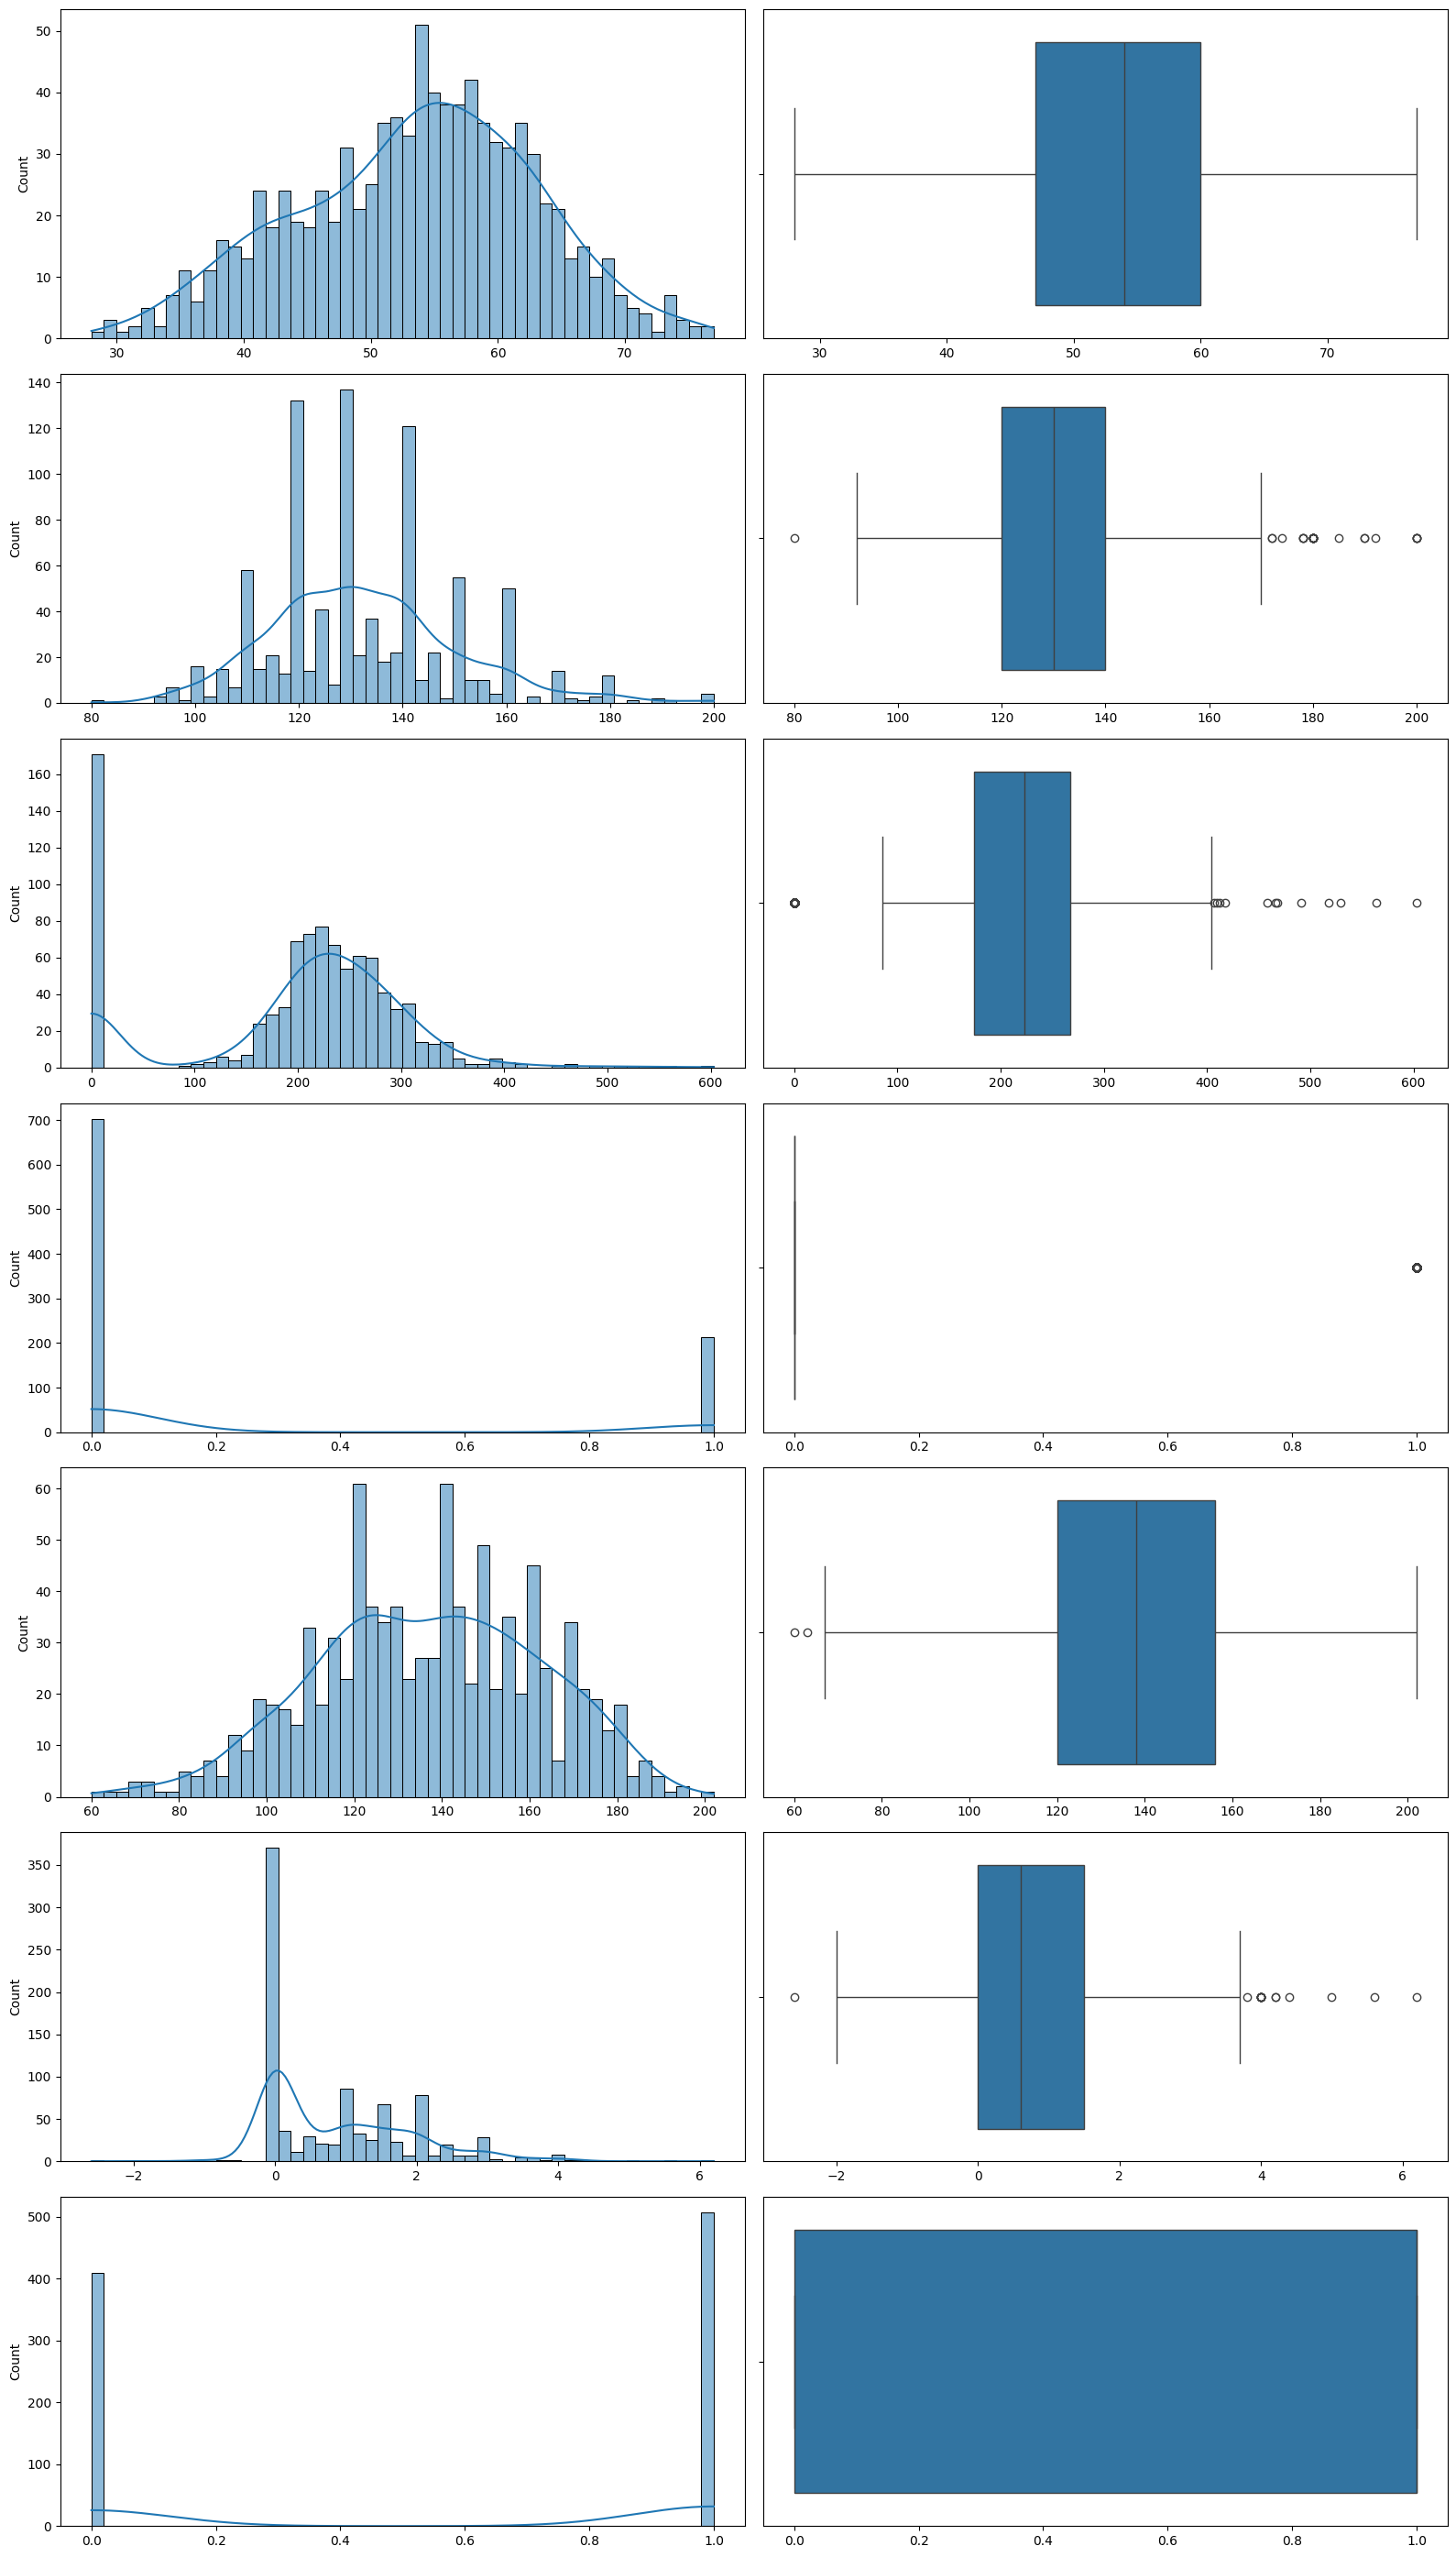

In [13]:
fig, axes = plt.subplots(df_num.shape[1], 2, figsize=(16, 4 * df_num.shape[1]))

for i, col_name in enumerate(df_num.columns):
    col_data = df_num[col_name].values  # Extract the values from the Pandas Series
    sns.histplot(x=col_data, bins=50, kde=True, ax=axes[i, 0])
    sns.boxplot(x=col_data, ax=axes[i, 1])

fig.tight_layout()
plt.show()


In [14]:
df_cat = df.select_dtypes(include='object').copy()
df_cat.head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


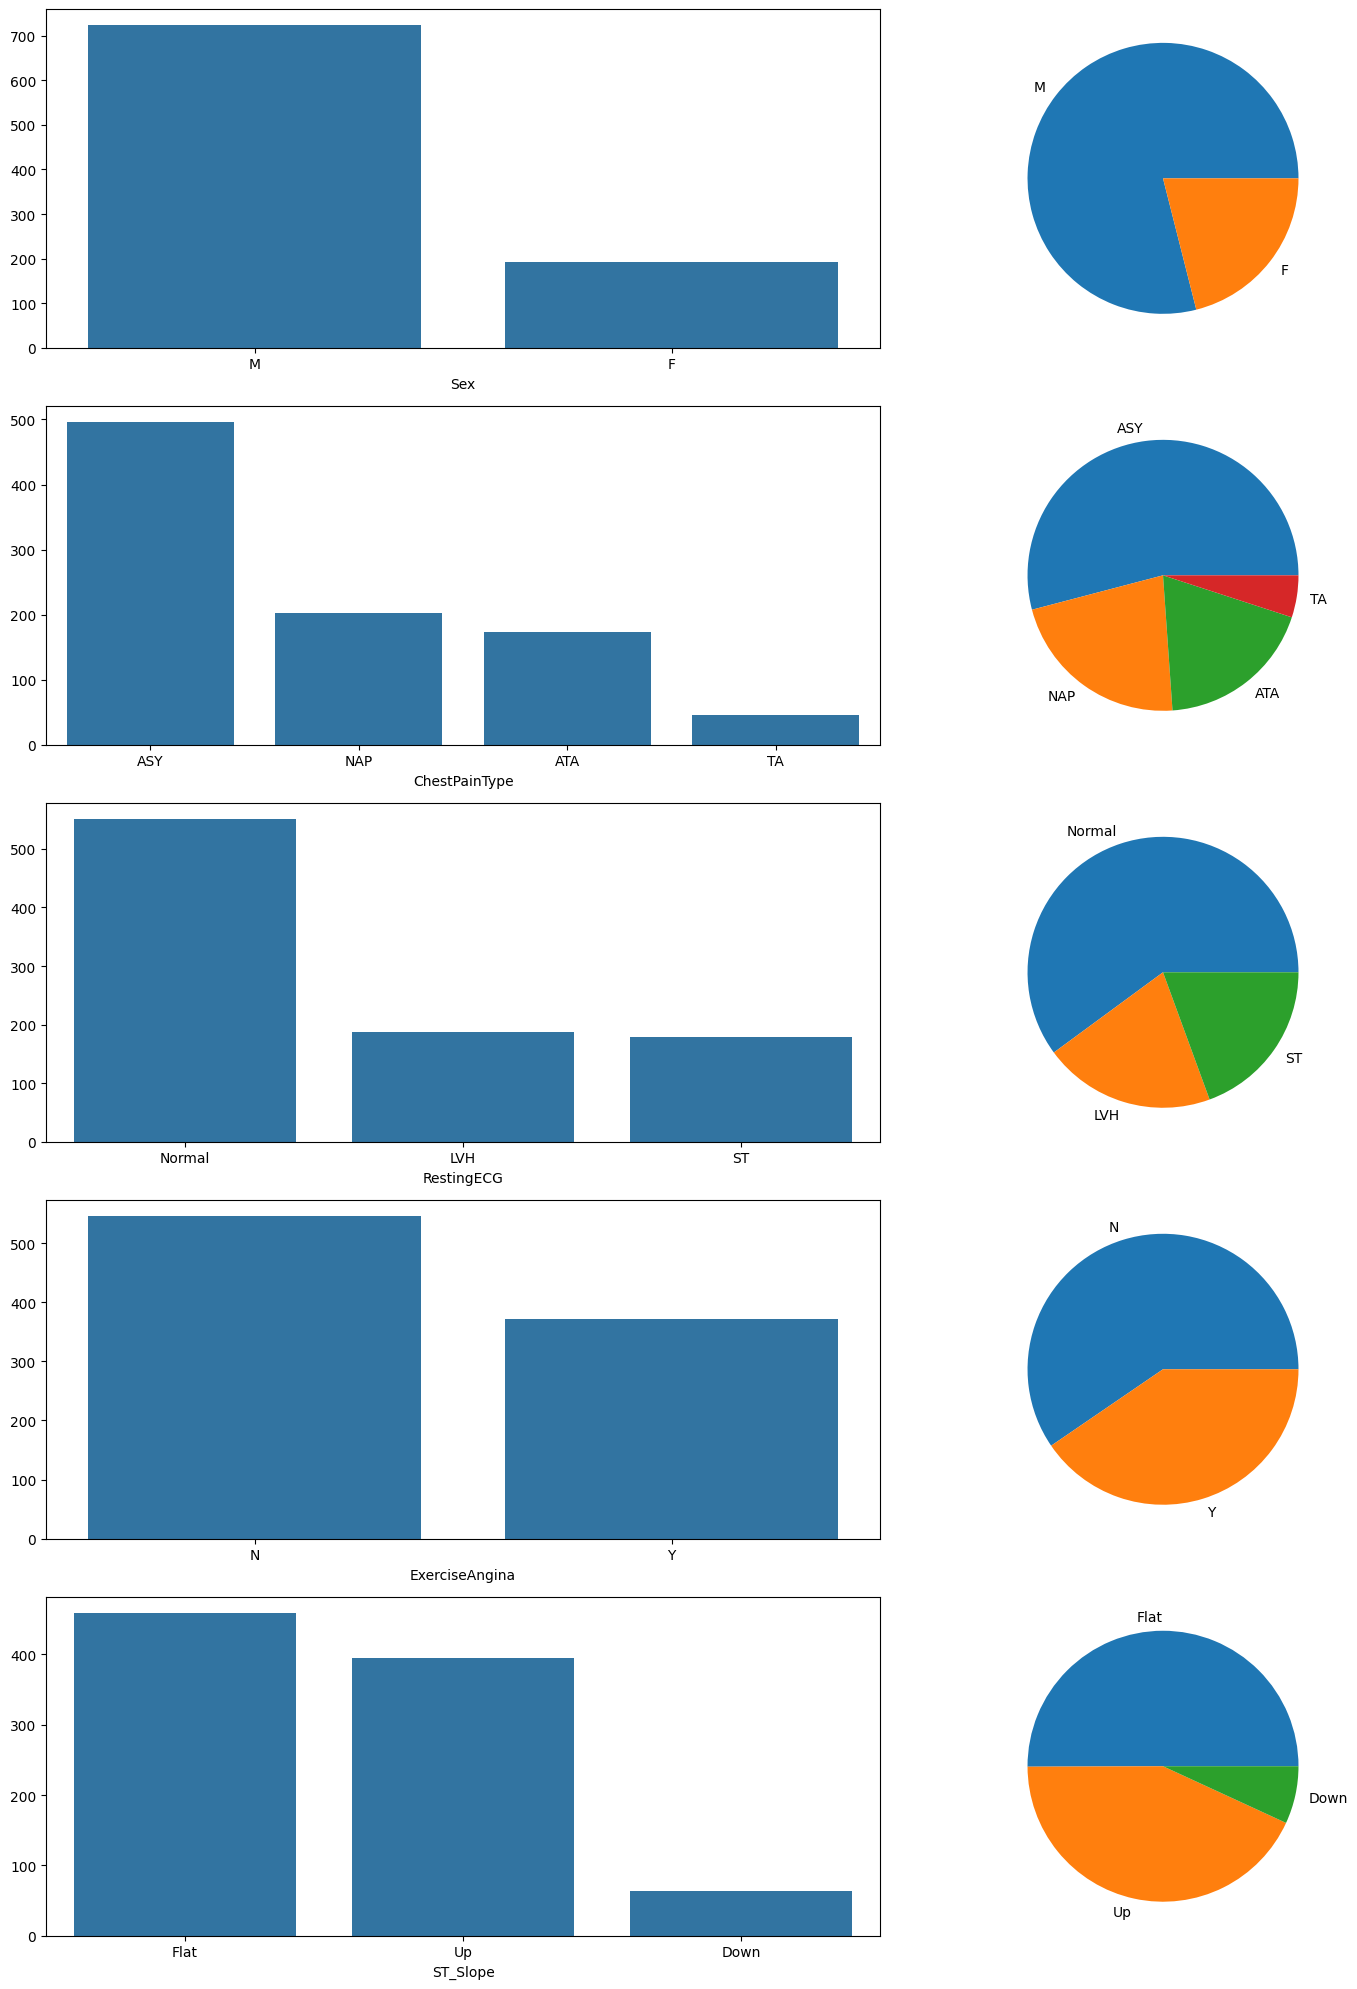

In [15]:
# Check if there are categorical columns
if df_cat.shape[1] > 0:
    # Now you can proceed with plotting
    fig, axes = plt.subplots(df_cat.shape[1], 2, figsize=(16, 4 * df_cat.shape[1]))

    for i, col_name in enumerate(df_cat.columns):
        col_data = df_cat[col_name]

        # Create bar plot
        value_counts = col_data.value_counts()
        count = value_counts.values
        labels = value_counts.index
        sns.barplot(x=labels, y=count, orient='v', ax=axes[i, 0])

        # Create pie chart
        axes[i, 1].pie(count, labels=labels)

    fig.tight_layout()
    plt.show()
else:
    print("No categorical columns found in the DataFrame.")

## Maping, scaling and transforming data

In [16]:
obj_columns = [x for x in df.columns if df[x].dtype =='object']
print(obj_columns)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [17]:
for n in obj_columns:
    print(f'{n} column: {df[n].unique()}')

Sex column: ['M' 'F']
ChestPainType column: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG column: ['Normal' 'ST' 'LVH']
ExerciseAngina column: ['N' 'Y']
ST_Slope column: ['Up' 'Flat' 'Down']


In [18]:
encoder = LabelEncoder()

for n in obj_columns:
    df[n] = encoder.fit_transform(df[n])

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


Scaling in Ada boost model is not a primary importance. it may improve speed of convergance but we are using a relavtievly small data set. WE will leave this point and possibly get back to it depending on the results of the model.

# Feature selection

AdaBoost is an ensemble learning method, and its nature allows it to handle feature selection implicitly to some extent. AdaBoost assigns different weights to the weak learners (usually decision trees) during the training process, giving more emphasis to features that are more informative for the task at hand. Therefore, explicit feature selection is not always required when using AdaBoost.

However we will look at their correlation to get some ideas and possibly use that knowlage to tune the model if it yields unsatisfactory results

In [20]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

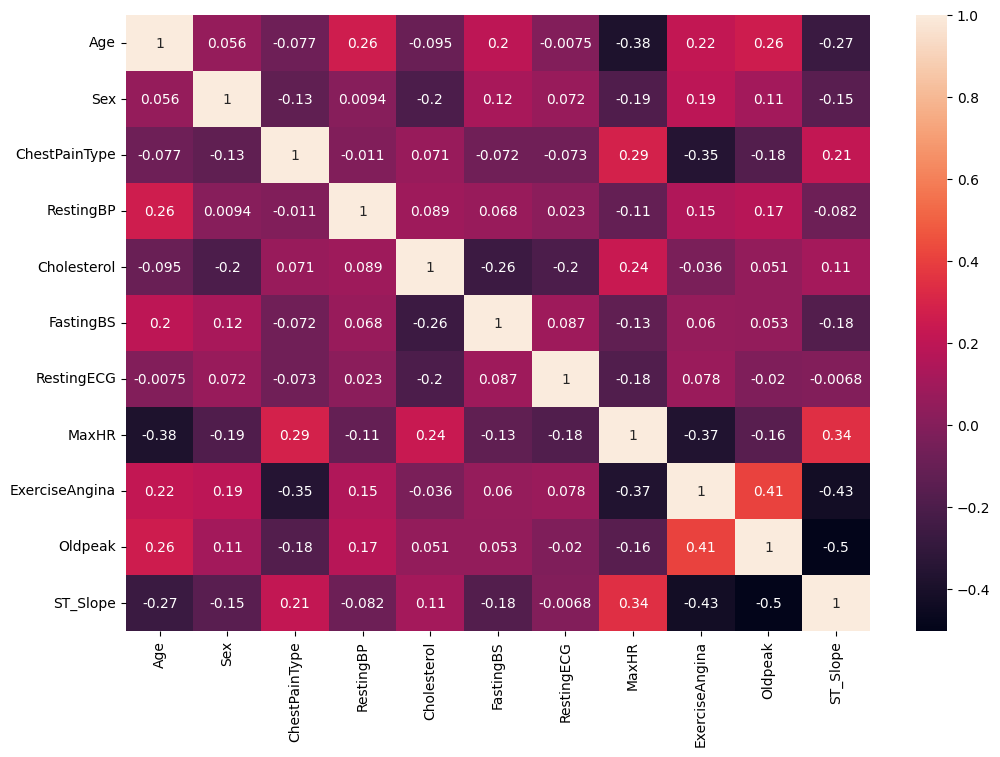

In [21]:
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(X.corr(), annot=True)
plt.show()

In [22]:
cor_target = abs(df.corr()["HeartDisease"])
relevant_features = cor_target.sort_values(ascending=False)

relevant_features

HeartDisease      1.000000
ST_Slope          0.558541
ExerciseAngina    0.495490
Oldpeak           0.403638
MaxHR             0.401410
ChestPainType     0.388592
Sex               0.305118
Age               0.282012
FastingBS         0.267994
Cholesterol       0.231479
RestingBP         0.117990
RestingECG        0.057393
Name: HeartDisease, dtype: float64

## Hyperparameters tuning

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
}

ada_model = AdaBoostClassifier(algorithm='SAMME')


grid_search = GridSearchCV(ada_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 100}
Test Accuracy: 0.875


Now i will try too see how different df do. I want to compare the data we created earlier.
WE will need to make the scaling and fitting of each:  
 2) df_filled       - where we filled missing values with mean  
 3) df_dropped      - where we dropped fastingbs column as it was missing 704 records with zero values but left zero values in cholesterl  
 4) df_dropped_two  - where we droped fasting columns and dropped all the ROWS in cholesterol with value zero


In [25]:
list_of_df = [df_filled, df_dropped, df_dropped_two]
list_of_df_names = ['df_filled', 'df_dropped', 'df_dropped_two']

num_on_list = len(list_of_df_names) - len(list_of_df_names)


In [26]:
# WE iterate through each df and create a list of columns needed to be encoded
for i in list_of_df:
    object_columns = [x for x in i.columns if i[x].dtype =='object']
    
    # We encode non numerical values
    for x in obj_columns:
        encoder = LabelEncoder()
        i[x] = encoder.fit_transform(i[x])

    # WE declare features and targets
    X = i.drop('HeartDisease', axis=1)
    y = i['HeartDisease']

    # We split into train and test sizes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # we search for most productive grid of parameters in each 
    param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    }

    ada_model = AdaBoostClassifier(algorithm='SAMME')


    grid_search = GridSearchCV(ada_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"Best Hyperparameters in {list_of_df_names[num_on_list]}:", grid_search.best_params_)

    # Evaluate the model with best hyperparameters on the test set
    best_model = grid_search.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print(f"Test Accuracy for {list_of_df_names[num_on_list]}:", test_accuracy)

    num_on_list += 1

num_on_list = 0
    

Best Hyperparameters in df_filled: {'learning_rate': 0.5, 'n_estimators': 50}
Test Accuracy for df_filled: 0.875
Best Hyperparameters in df_dropped: {'learning_rate': 0.5, 'n_estimators': 200}
Test Accuracy for df_dropped: 0.8804347826086957
Best Hyperparameters in df_dropped_two: {'learning_rate': 0.1, 'n_estimators': 100}
Test Accuracy for df_dropped_two: 0.8733333333333333


Unfortunatylly all data frames got a decent result and a result not far from our main column. 
differances are small and may be to the randoms_state used.
Based on that i got no clear answer showing that those features are corrupted.

So i decided to use the last df, where the most records are dropped as it uses suggest it is most efficient.

## Build models

In [27]:
X = df_dropped_two.drop('HeartDisease', axis=1)
y = df_dropped_two['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [28]:
n_estimators = 100
learning_rate = 0.1

# Create an instance of AdaBoostClassifier with chosen hyperparameters
model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, algorithm='SAMME')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Evaluate model

In [29]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Display a classification report
class_report = classification_report(y_test, y_pred)
print('\nClassification Report:')
print(class_report)

Accuracy: 0.8733

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        71
           1       0.88      0.87      0.88        79

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



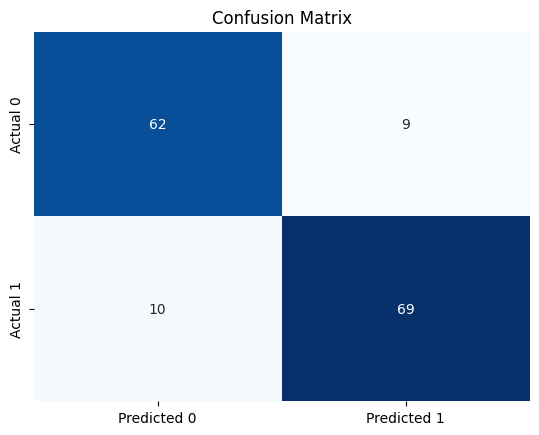

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()